# Example of Denoising Autoencoder with MNIST dataset

In [1]:
# First install the library

# %pip install rapidae

Since Rapidae uses the new version of Keras 3, this allows the use of different backends. 
We can select among the 3 available backends (Tensorflow, Pytorch and Jax) by modifying the environment variable "KERAS_BACKEND".
In the next cell we can define it.

In [2]:
import os

os.environ["KERAS_BACKEND"] = "torch"

In [3]:
import sys

#notebook_dir = os.path.abspath('')
#sys.path.append(os.path.join(notebook_dir, '..', 'src'))

import keras

from rapidae.data.datasets import load_MNIST
from rapidae.data.utils import display_diff, add_noise
from rapidae.models.ae.ae_model import AE
from rapidae.models.base.default_architectures import VanillaEncoder, VanillaDecoder
from rapidae.pipelines.training import TrainingPipeline

# For reproducibility in Keras 3. This will set:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
keras.utils.set_random_seed(1)

### Download and preprocess the dataset

Download and preprocess the dataset. In this example, the selected dataset is the well-known MNIST composed of handwritten number images.

The "persistant" parameter of the load_MNIST() serves as a flag to determine if we want the dataset to be cached in the datasets folder.

Train and test data are normalized and flatten since we are going to use a non convolutional autoencoder.

Since we want to train a denoising autoencoder, we also need to add some noise to the images.
The noise factor should be a float between 0 and 1 depending the intensity of the noise.

The used autoencoder to denoise the images is vanilla without convolutional layers so we need to flatten the images before we use it as inputs.

In [4]:
# Load MNIST dataset
x_train, y_train, x_test, y_test = load_MNIST(persistant=True)

# Add noise to the train and test data
x_train_noisy = add_noise(x_train, noise_factor=0.3)
x_test_noisy = add_noise(x_test, noise_factor=0.3)

# Flatten data
x_train = x_train.reshape(x_train.shape[0], -1).astype('float32') / 255
x_train_noisy = x_train_noisy.reshape(x_train_noisy.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1).astype('float32') / 255
x_test_noisy = x_test_noisy.reshape(x_test_noisy.shape[0], -1)

2024-01-15 13:07:25 [INFO]: train-images-idx3-ubyte.gz already exists.
2024-01-15 13:07:25 [INFO]: train-labels-idx1-ubyte.gz already exists.
2024-01-15 13:07:25 [INFO]: t10k-images-idx3-ubyte.gz already exists.
2024-01-15 13:07:25 [INFO]: t10k-labels-idx1-ubyte.gz already exists.


### Model creation

Since the denoising autoencoder in structure is a vanilla autoencoder (only its functionality varies), the encoder and decoder are the vanilla ones, depth of the network and number of neurons per layer can be defined by using the layers_conf parameter.
The latent_dim determinates the dimensionality of the latent space.

In [5]:
# Model creation
model = AE(input_dim=x_train_noisy.shape[1], latent_dim=10,
           encoder=VanillaEncoder, decoder=VanillaDecoder, layers_conf=[64, 32])

### Training pipeline

Define the training pipeline. There you can fix some hyperparameters related to the training phase of the autoencoder, like learning rate, bath size, numer of epochs, etc.
Here you can define callbacks to the model.
Also the pipeline's name can be customized to facilitate the identification of the corresponding folder with the saved models inside output_dir folder.

In [6]:
pipe = TrainingPipeline(name='training_pipeline_denoising_ae',
                        model=model, num_epochs=50)

trained_model = pipe(x=x_train_noisy, y=x_train)

2024-01-15 13:07:27 [INFO]: +++ training_pipeline_denoising_ae +++
2024-01-15 13:07:27 [INFO]: Creating folder in ../output_dir/training_pipeline_denoising_ae_2024-01-15_13-07-27


Epoch 1/50

Epoch 1: loss improved from inf to 0.09122, saving model to ../output_dir/training_pipeline_denoising_ae_2024-01-15_13-07-27/model.weights.h5
469/469 - 2s - 4ms/step - loss: 0.0912
Epoch 2/50

Epoch 2: loss improved from 0.09122 to 0.06862, saving model to ../output_dir/training_pipeline_denoising_ae_2024-01-15_13-07-27/model.weights.h5
469/469 - 2s - 4ms/step - loss: 0.0686
Epoch 3/50

Epoch 3: loss improved from 0.06862 to 0.06407, saving model to ../output_dir/training_pipeline_denoising_ae_2024-01-15_13-07-27/model.weights.h5
469/469 - 2s - 3ms/step - loss: 0.0641
Epoch 4/50

Epoch 4: loss improved from 0.06407 to 0.06193, saving model to ../output_dir/training_pipeline_denoising_ae_2024-01-15_13-07-27/model.weights.h5
469/469 - 2s - 4ms/step - loss: 0.0619
Epoch 5/50

Epoch 5: loss improved from 0.06193 to 0.05995, saving model to ../output_dir/training_pipeline_denoising_ae_2024-01-15_13-07-27/model.weights.h5
469/469 - 2s - 4ms/step - loss: 0.0600
Epoch 6/50

Epoch 6

### Evaluation step 

Finally the original images with noise can be graphically compared with the output images of the autoencoder.
As you can see, the added noise of the input images has largely disappeared.

 47/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


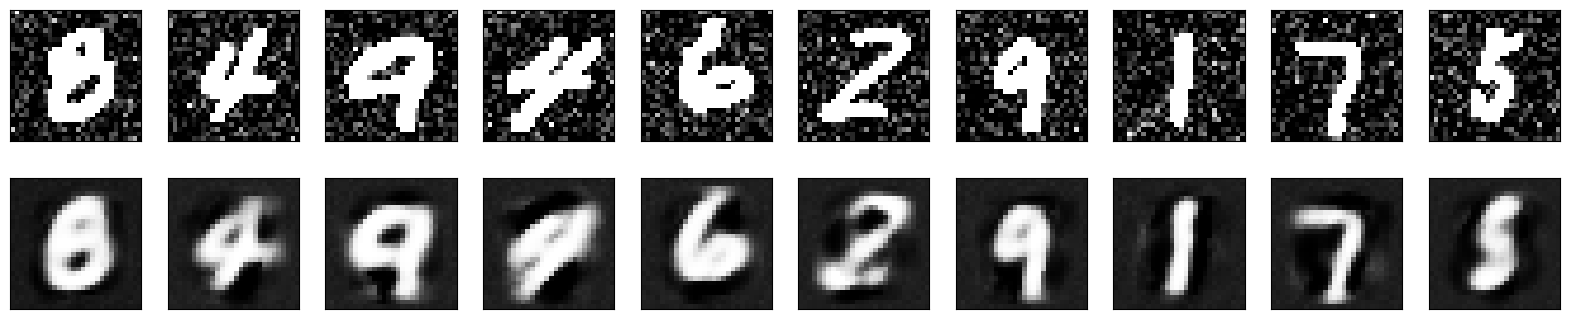

In [7]:
y_hat = trained_model.predict(x_test_noisy)
display_diff(x_test_noisy, y_hat['recon'])